In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
import os

In [25]:
path = 'dataset/'
training_data_dir = os.path.join(path, 'train')
testing_data_dir = os.path.join(path, 'test')

output_dir = os.path.join('models/')

In [15]:
os.mkdir(output_dir)

In [22]:
IMAGE_SIZE = 224
EPOCHS = 20
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [17]:
base_model = tf.keras.applications.mobilenet.MobileNet(weights = 'imagenet', include_top=False)

In [20]:
from keras.applications.mobilenet import preprocess_input

training_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.1)
validation_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [27]:
# Data Preparation

training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = 'binary'
)

validation_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation',
    class_mode = 'binary'
)

test_generator = test_data_generator.flow_from_directory(
    testing_data_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False
)

Found 534 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [30]:
# Creating our model on top of MobileNet

def create_model():
    model = tf.keras.models.Sequential([base_model])
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dense(512, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    return model

In [45]:
model = create_model()

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,853,377
Trainable params: 2,624,513
Non-trainable params: 3,228,864
____________________________________

In [47]:
base_model.trainable = False

In [48]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 1e-4), metrics = ['accuracy'])

In [49]:
history = model.fit(training_generator, 
                   steps_per_epoch = len(training_generator.filenames) // BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = validation_generator,
                   validation_steps = len(validation_generator.filenames) // BATCH_SIZE,
                   callbacks = [
#                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                       tf.keras.callbacks.ModelCheckpoint('/models/model_{epoch}_{val_accuracy:.3f}.h5', save_best_only = True,
                                                         save_weights_only = False, monitor = 'val_accuracy')
                   ])

Epoch 1/20
16/16 [==============================] - 29s 2s/step - loss: 0.5550 - accuracy: 0.7410 - val_loss: 0.5349 - val_accuracy: 0.7812
Epoch 2/20
16/16 [==============================] - 34s 2s/step - loss: 0.4497 - accuracy: 0.8068 - val_loss: 0.5559 - val_accuracy: 0.7812
Epoch 3/20
16/16 [==============================] - 33s 2s/step - loss: 0.3626 - accuracy: 0.8506 - val_loss: 0.4865 - val_accuracy: 0.7812
Epoch 4/20
16/16 [==============================] - 35s 2s/step - loss: 0.2840 - accuracy: 0.9004 - val_loss: 0.7303 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 34s 2s/step - loss: 0.2989 - accuracy: 0.8964 - val_loss: 0.5440 - val_accuracy: 0.7500
Epoch 6/20
16/16 [==============================] - 33s 2s/step - loss: 0.2493 - accuracy: 0.9084 - val_loss: 0.3639 - val_accuracy: 0.8125
Epoch 7/20
16/16 [==============================] - 35s 2s/step - loss: 0.1839 - accuracy: 0.9442 - val_loss: 0.4004 - val_accuracy: 0.7812
Epoch 8/20
16/16 [==

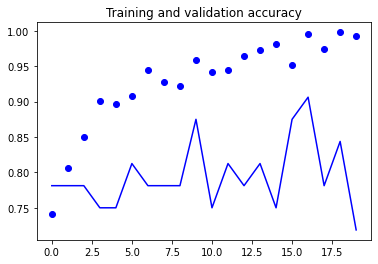

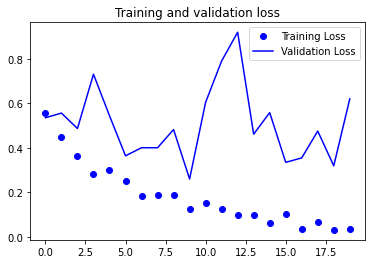

In [58]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [63]:
model.save('models/palmistry_model_v1.h5')

In [50]:
# Building 2nd Model Without using Transfer Learning

In [54]:
def create_model_2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2 ,2),
        tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    return model
    

In [55]:
model_v2 = create_model_2()

In [56]:
model_v2.compile(loss = 'binary_crossentropy',
                optimizer = RMSprop(lr = 1e-4),
                metrics = ['accuracy'])

In [59]:
history_v2 = model_v2.fit(training_generator, 
                   steps_per_epoch = len(training_generator.filenames) // BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = validation_generator,
                   validation_steps = len(validation_generator.filenames) // BATCH_SIZE
                         )

Epoch 1/20
16/16 [==============================] - 67s 4s/step - loss: 0.5363 - accuracy: 0.7629 - val_loss: 0.5068 - val_accuracy: 0.7812
Epoch 2/20
16/16 [==============================] - 69s 4s/step - loss: 0.4264 - accuracy: 0.8048 - val_loss: 0.4548 - val_accuracy: 0.8125
Epoch 3/20
16/16 [==============================] - 70s 4s/step - loss: 0.3423 - accuracy: 0.8546 - val_loss: 0.3100 - val_accuracy: 0.9688
Epoch 4/20
16/16 [==============================] - 62s 4s/step - loss: 0.3002 - accuracy: 0.8645 - val_loss: 0.6189 - val_accuracy: 0.6875
Epoch 5/20
16/16 [==============================] - 60s 4s/step - loss: 0.2214 - accuracy: 0.8884 - val_loss: 0.7369 - val_accuracy: 0.6562
Epoch 6/20
16/16 [==============================] - 61s 4s/step - loss: 0.2356 - accuracy: 0.9064 - val_loss: 0.3695 - val_accuracy: 0.7188
Epoch 7/20
16/16 [==============================] - 67s 4s/step - loss: 0.1497 - accuracy: 0.9522 - val_loss: 0.1990 - val_accuracy: 0.9375
Epoch 8/20
16/16 [==

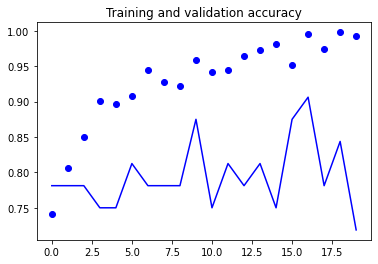

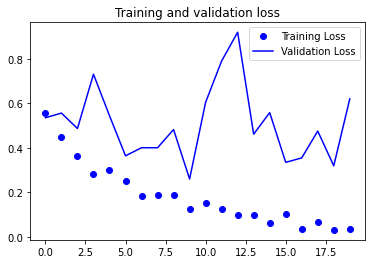

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [62]:
model_v2.save('models/palmistry_model_v2.h5')